In [2]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import pickle
import time

from matplotlib import pyplot as plt

from scipy import stats
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import concurrent.futures
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import sys
import logging
import argparse # Argument parsing
import math
from collections import defaultdict
import concurrent
from concurrent.futures import ThreadPoolExecutor  # Importing specific executor for clarity

# Nearest neighbor search
import sklearn
from sklearn.neighbors import BallTree

# Special functions and optimizations
from scipy.special import gamma, kv  # Bessel function and gamma function
from scipy.stats import multivariate_normal  # Simulation
from scipy.optimize import minimize
from scipy.spatial.distance import cdist  # For space and time distance
from scipy.spatial import distance  # Find closest spatial point
from scipy.optimize import differential_evolution
from typing import Callable, Union, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

# Custom imports
from GEMS_TCO import orbitmap
from GEMS_TCO import kernels

Initiate instsance

In [3]:
df = pd.read_csv("C:\\Users\\joonw\\TCO\\data_engineering\\data_2024\\data_24_07_0131_N510_E110120.csv")
instance = orbitmap.MakeOrbitdata(df, 5,10,110,120)

# Load the dictionary from the pickle file
filepath = "C:\\Users\\joonw\\TCO\\data_engineering\\data_2024\\sparse_cen_map24_01.pkl"

with open(filepath, 'rb') as pickle_file:
    coarse_dict_24_1 = pickle.load(pickle_file)

sample_df = coarse_dict_24_1['y24m01day01_hm02:12']

Set coarse coordinates

In [4]:
rho_lat = 20
rho_lon = 20
lat_n = sample_df['Latitude'].unique()[::rho_lat]
lon_n = sample_df['Longitude'].unique()[::rho_lon]

print(len(lat_n))
print(len(lon_n))

5
10


Note that

# Efficiency: isin is vectorized, leveraging pandas' optimized internals for filtering
# tr  = ddf.apply(lambda x: (x.Latitude in lat_n) and (x.Longitude in lon_n), axis=1) 

In [5]:
# Set coarse coordinates

coarse_dicts = {}

years = ['2023','2024']
for year in years:
    for month in range(1, 13):  # Iterate over all months
        filepath = f"C:\\Users\\joonw\\TCO\\data_engineering\\data_{year}\\sparse_cen_map{year[2:]}_{month:02d}.pkl"
        with open(filepath, 'rb') as pickle_file:
            loaded_map = pickle.load(pickle_file)
            for key in loaded_map:
                tmp_df = loaded_map[key]
                coarse_filter = (tmp_df['Latitude'].isin(lat_n)) & (tmp_df['Longitude'].isin(lon_n))
                coarse_dicts[f"{year}_{month:02d}_{key}"] = tmp_df[coarse_filter].reset_index(drop=True)

        print(f"Finished processing {year} {month}.")


Finished processing 2023 1.
Finished processing 2023 2.
Finished processing 2023 3.
Finished processing 2023 4.
Finished processing 2023 5.
Finished processing 2023 6.
Finished processing 2023 7.
Finished processing 2023 8.
Finished processing 2023 9.
Finished processing 2023 10.
Finished processing 2023 11.
Finished processing 2023 12.
Finished processing 2024 1.
Finished processing 2024 2.
Finished processing 2024 3.
Finished processing 2024 4.
Finished processing 2024 5.
Finished processing 2024 6.
Finished processing 2024 7.
Finished processing 2024 8.
Finished processing 2024 9.
Finished processing 2024 10.
Finished processing 2024 11.
Finished processing 2024 12.


For large-scale DataFrame concatenation, the list-based approach is the preferred way to go. both faster and more robust.

In [19]:
df_list = []

for key in coarse_dicts:
    df_list.append(coarse_dicts[key])

df_entire = pd.concat(df_list, axis=0, ignore_index=True)


In [6]:
key_list = list(coarse_dicts.keys())
train_set = []
test_set = []
for i in range(len(coarse_dicts)):
    if i<= 4000:
        train_set.append(coarse_dicts[key_list[i]]) 
    else:
        test_set.append(coarse_dicts[key_list[i]]) 

In [7]:
train_set = pd.concat(train_set, axis=0, ignore_index=True)
test_set = pd.concat(test_set, axis=0, ignore_index=True)

Gp testing

In [19]:
# Gaussian Process-based Feature Extraction
class GPFeatureExtractor:
    def __init__(self, kernel=None):
        self.kernel = kernel if kernel else Matern(length_scale=1.0, nu=1.5)
        self.gp = GaussianProcessRegressor(kernel=self.kernel)

    def fit(self, X, y):
        self.gp.fit(X, y)

    def extract_features(self, X):
        mean, std = self.gp.predict(X, return_std=True)
        return mean, std

# Custom Dataset for Ozone Data
class OzoneDataset(Dataset):
    def __init__(self, data, num_latitude, num_longitude):
        self.data = data
        self.num_latitude = num_latitude
        self.num_longitude = num_longitude
        self.latitudes = sorted(data['Latitude'].unique())
        self.longitudes = sorted(data['Longitude'].unique())
        self.lat_lon_map = {
            (row['Latitude'], row['Longitude']): (self.latitudes.index(row['Latitude']), self.longitudes.index(row['Longitude']))
            for _, row in data.iterrows()
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        lat_idx, lon_idx = self.lat_lon_map[(row['Latitude'], row['Longitude'])]
        return torch.tensor([lat_idx, lon_idx], dtype=torch.float32), torch.tensor(row['ColumnAmountO3'], dtype=torch.float32)

# Parameters
lat_number = 5
lon_number = 10
batch_size = 16
train_dataset = OzoneDataset(test_set, lat_number, lon_number)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.25):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output


# Initialize GP feature extractor and train
gp_extractor = GPFeatureExtractor()
coordinates = np.array([(row['Latitude'], row['Longitude']) for _, row in train_set.iterrows()])
ozone_values = train_set['ColumnAmountO3'].values
gp_extractor.fit(coordinates, ozone_values)

# Extract features
mean_features, std_features = gp_extractor.extract_features(coordinates)

# Initialize LSTM model
input_size = 2  # Lat and Lon
hidden_size = 128
output_size = lat_number * lon_number
model = LSTMModel(input_size, hidden_size, output_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    total_loss = 0.0
    start_time = time.time()
    for coordinates, ozone_values in train_loader:
        coordinates, ozone_values = coordinates.to(device), ozone_values.to(device)
        optimizer.zero_grad()
        predictions = model(coordinates)
        loss = criterion(predictions, ozone_values)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    end_time = time.time()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}, Time: {end_time - start_time:.2f}s")

# Save the model
model_path = f'/home/jl2815/tco/models/save_models/gp_lstm_{lat_number}_{lon_number}.pth'
torch.save(model.state_dict(), model_path)

MemoryError: Unable to allocate 149. GiB for an array with shape (20009901225,) and data type float64

Step 1: Pretrained CNN for Feature Extraction
The CNN processes spatial grids (latitude × longitude) and outputs flattened features.

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import torch.optim as optim

class FeatureExtractorCNN(nn.Module):
    def __init__(self, cnn_channels, output_size):
        super(FeatureExtractorCNN, self).__init__()
        self.conv1 = nn.Conv2d(cnn_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(64 * 5 * 10, output_size)  # Adjust based on grid size (5 × 10 here)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x


Step 2: Dataset Preparation
Precompute CNN features for spatial grids and prepare multi-scale sequences.

In [83]:
class OzoneDataset(Dataset):
    def __init__(self, data, cnn_model, num_latitude, num_longitude, daily_cycle_len, monthly_cycle_len, three_month_cycle_len):
        self.data = data
        self.cnn_model = cnn_model.eval()  # Use the CNN in evaluation mode for preprocessing
        self.num_latitude = num_latitude
        self.num_longitude = num_longitude
        self.daily_cycle_len = daily_cycle_len
        self.monthly_cycle_len = monthly_cycle_len
        self.three_month_cycle_len = three_month_cycle_len
        self.cnn_features = self.precompute_cnn_features()
        self.prepared_data = self.prepare_data()

    def precompute_cnn_features(self):
        latitudes = sorted(self.data['Latitude'].unique())
        longitudes = sorted(self.data['Longitude'].unique())
        time_steps = sorted(self.data['Hours_elapsed'].unique())

        # Precompute CNN features for all grids
        cnn_features = []
        for t in time_steps:
            sub_data = self.data[self.data['Hours_elapsed'] == t]
            grid = np.zeros((self.num_latitude, self.num_longitude))
            for _, row in sub_data.iterrows():
                lat_idx = latitudes.index(row['Latitude'])
                lon_idx = longitudes.index(row['Longitude'])
                grid[lat_idx, lon_idx] = row['ColumnAmountO3']

            # Convert grid to tensor and pass through CNN
            grid_tensor = torch.tensor(grid, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
            with torch.no_grad():
                spatial_features = self.cnn_model(grid_tensor).view(-1)  # Flattened CNN output
            cnn_features.append(spatial_features.numpy())
        return np.array(cnn_features)

    def prepare_data(self):
        X_daily, X_monthly, X_three_month, y = [], [], [], []
        for i in range(len(self.cnn_features) - self.three_month_cycle_len):
            # Daily cycle: Last few intervals (3 time steps)
            daily_seq = self.cnn_features[i:i + self.daily_cycle_len]

            # Monthly cycle: Consecutive 90 intervals
            monthly_seq = self.cnn_features[i:i + self.monthly_cycle_len]

            # Three-month cycle: Snapshots at 1-month intervals
            three_month_seq = self.cnn_features[i:i + self.three_month_cycle_len:self.monthly_cycle_len]

            # Append inputs and target
            X_daily.append(daily_seq)
            X_monthly.append(monthly_seq)
            X_three_month.append(three_month_seq)
            y.append(self.cnn_features[i + self.three_month_cycle_len])  # Target is the CNN feature of the next step
        return np.array(X_daily), np.array(X_monthly), np.array(X_three_month), np.array(y)

    def __len__(self):
        return len(self.prepared_data[0])

    def __getitem__(self, idx):
        X_daily, X_monthly, X_three_month, y = self.prepared_data
        return (
            torch.tensor(X_daily[idx], dtype=torch.float32),
            torch.tensor(X_monthly[idx], dtype=torch.float32),
            torch.tensor(X_three_month[idx], dtype=torch.float32),
            torch.tensor(y[idx], dtype=torch.float32)
        )


Step 3: Multi-Scale LSTM Model
Each cycle is processed by its own LSTM, and the outputs are combined for the final prediction.

In [84]:
class MultiScaleLSTM(nn.Module):
    def __init__(self, lstm_hidden_size, lstm_num_layers=1, lstm_dropout=0.25):
        super(MultiScaleLSTM, self).__init__()
        # LSTM layers for daily, monthly, and three-month cycles
        self.lstm_daily = nn.LSTM(64, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)
        self.lstm_monthly = nn.LSTM(64, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)
        self.lstm_three_month = nn.LSTM(64, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)

        # Fully connected layer for combining outputs
        self.fc = nn.Linear(lstm_hidden_size * 3, 1)

    def forward(self, X_daily, X_monthly, X_three_month):
        # Process each cycle with its LSTM
        lstm_out_daily, _ = self.lstm_daily(X_daily)
        lstm_out_monthly, _ = self.lstm_monthly(X_monthly)
        lstm_out_three_month, _ = self.lstm_three_month(X_three_month)

        # Concatenate the outputs
        combined_features = torch.cat((lstm_out_daily[:, -1, :], lstm_out_monthly[:, -1, :], lstm_out_three_month[:, -1, :]), dim=1)

        # Final prediction
        output = self.fc(combined_features)
        return output


Step 4 training pipe line

In [86]:
# Define parameters
num_latitude = 5
num_longitude = 10
cnn_channels = 1  # like grayscale images, ozone is represented as a single value
cnn_output_size = 64  # It is not tied to the size of the input grid but rather to the complexity of the patterns we expect the CNN to learn.
daily_cycle_len = 8
monthly_cycle_len = 240
three_month_cycle_len = 720
lstm_hidden_size = 128 # Increasing lstm_hidden_size allows the LSTM to better capture long-term dependencies. but computational cost

# Load your data
data = df_entire

# Initialize CNN for feature extraction
cnn_model = FeatureExtractorCNN(cnn_channels, cnn_output_size)
cnn_model.eval()  # Set CNN to evaluation mode for feature extraction

# Prepare dataset
dataset = OzoneDataset(data, cnn_model, num_latitude, num_longitude, daily_cycle_len, monthly_cycle_len, three_month_cycle_len)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Initialize Multi-Scale LSTM
model = MultiScaleLSTM(lstm_hidden_size=128, lstm_num_layers=1, lstm_dropout=0.1)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    for X_daily, X_monthly, X_three_month, y in dataloader:
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_daily, X_monthly, X_three_month)

        # Compute loss
        loss = criterion(predictions, y.view(-1))
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")


c:\Users\joonw\anaconda3\envs\jl2815\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn(
c:\Users\joonw\anaconda3\envs\jl2815\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\joonw\anaconda3\envs\jl2815\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([960])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Loss: 39.3152
Epoch 2/20, Loss: 41.6272
Epoch 3/20, Loss: 39.7652
Epoch 4/20, Loss: 39.6117
Epoch 5/20, Loss: 41.7547
Epoch 6/20, Loss: 41.4694
Epoch 7/20, Loss: 40.2820
Epoch 8/20, Loss: 42.5225
Epoch 9/20, Loss: 40.7666
Epoch 10/20, Loss: 41.1398
Epoch 11/20, Loss: 39.9845
Epoch 12/20, Loss: 39.5781
Epoch 13/20, Loss: 40.1565
Epoch 14/20, Loss: 40.5254
Epoch 15/20, Loss: 40.8880
Epoch 16/20, Loss: 39.6964
Epoch 17/20, Loss: 40.6008
Epoch 18/20, Loss: 41.7216
Epoch 19/20, Loss: 41.5865
Epoch 20/20, Loss: 40.4669


In [ ]:
# CNN Model for Spatial Feature Extraction
class FeatureExtractorCNN(nn.Module):
    def __init__(self, cnn_channels, output_size):
        super(FeatureExtractorCNN, self).__init__()
        self.conv1 = nn.Conv2d(cnn_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(64 * 5 * 10, output_size)  # Adjust based on grid size (5x10 here)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Custom Dataset for Ozone Data
class OzoneDataset(Dataset):
    def __init__(self, data, num_latitude, num_longitude, daily_cycle_len, monthly_cycle_len, three_month_cycle_len):
        self.data = data
        self.num_latitude = num_latitude
        self.num_longitude = num_longitude
        self.daily_cycle_len = daily_cycle_len
        self.monthly_cycle_len = monthly_cycle_len
        self.three_month_cycle_len = three_month_cycle_len

        # Cache unique latitude/longitude indices for faster grid construction
        self.latitudes = sorted(data['Latitude'].unique())
        self.longitudes = sorted(data['Longitude'].unique())
        self.time_steps = sorted(data['Hours_elapsed'].unique())
        self.lat_lon_map = {
            (row['Latitude'], row['Longitude']): (self.latitudes.index(row['Latitude']), self.longitudes.index(row['Longitude']))
            for _, row in data.iterrows()
        }

        # Prepare data for sequences
        self.prepared_data = self.prepare_data()

    def prepare_data(self):
        X_daily, X_monthly, X_three_month, y = [], [], [], []
        for i in range(len(self.time_steps) - self.three_month_cycle_len):
            daily_seq, monthly_seq, three_month_seq = [], [], []

            for t in range(i, i + self.three_month_cycle_len):
                sub_data = self.data[self.data['Hours_elapsed'] == self.time_steps[t]]
                grid = np.zeros((self.num_latitude, self.num_longitude))
                
                for _, row in sub_data.iterrows():
                    lat_idx, lon_idx = self.lat_lon_map[(row['Latitude'], row['Longitude'])]
                    grid[lat_idx, lon_idx] = row['ColumnAmountO3']

                if t < i + self.daily_cycle_len:
                    daily_seq.append(grid)
                if t < i + self.monthly_cycle_len:
                    monthly_seq.append(grid)
                three_month_seq.append(grid)

            X_daily.append(torch.tensor(np.array(daily_seq), dtype=torch.float32))
            X_monthly.append(torch.tensor(np.array(monthly_seq), dtype=torch.float32))
            X_three_month.append(torch.tensor(np.array(three_month_seq), dtype=torch.float32))
            y.append(torch.tensor(np.array(three_month_seq[-1]), dtype=torch.float32))  # Target is last grid in the sequence

        return X_daily, X_monthly, X_three_month, y

    def __len__(self):
        return len(self.prepared_data[0])

    def __getitem__(self, idx):
        X_daily, X_monthly, X_three_month, y = self.prepared_data
        return X_daily[idx], X_monthly[idx], X_three_month[idx], y[idx]

# Multi-Scale LSTM for Temporal Modeling
class MultiScaleLSTM(nn.Module):
    def __init__(self, cnn_channels, cnn_output_size, lstm_hidden_size, lstm_num_layers=1, lstm_dropout=0.25):
        super(MultiScaleLSTM, self).__init__()
        self.cnn = FeatureExtractorCNN(cnn_channels, cnn_output_size)
        self.lstm_daily = nn.LSTM(cnn_output_size, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)
        self.lstm_monthly = nn.LSTM(cnn_output_size, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)
        self.lstm_three_month = nn.LSTM(cnn_output_size, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)
        # self.fc = nn.Linear(lstm_hidden_size * 3, 1)
        self.fc = nn.Linear(lstm_hidden_size * 3, 5 * 10)

    def forward(self, X_daily, X_monthly, X_three_month):
        def extract_features(X_seq):
            batch_size, seq_len, height, width = X_seq.shape
            # Process each timestep with CNN
            features = [self.cnn(X_seq[:, t].unsqueeze(1)) for t in range(seq_len)]
            return torch.stack(features, dim=1)  # Shape: [batch_size, seq_len, cnn_output_size]

        # Extract spatial features for each sequence
        daily_features = extract_features(X_daily)
        monthly_features = extract_features(X_monthly)
        three_month_features = extract_features(X_three_month)

        # Process temporal features using LSTMs
        lstm_out_daily, _ = self.lstm_daily(daily_features)
        lstm_out_monthly, _ = self.lstm_monthly(monthly_features)
        lstm_out_three_month, _ = self.lstm_three_month(three_month_features)

        # Concatenate the final outputs from each LSTM
        combined_features = torch.cat((lstm_out_daily[:, -1, :], lstm_out_monthly[:, -1, :], lstm_out_three_month[:, -1, :]), dim=1)

        output = self.fc(combined_features)
        output = output.view(-1, 5, 10)  # Reshape to grid dimensions

        # Final prediction
        return output

# Parameters
num_latitude = 5
num_longitude = 10
cnn_channels = 1  # Grayscale-like input
cnn_output_size = 64  # Number of features extracted by CNN
daily_cycle_len = 8
monthly_cycle_len = 24    #240
three_month_cycle_len = 60  # 720 tmp for week
lstm_hidden_size = 64 # 128

# Load dataset (example)
data = df_entire
dataset = OzoneDataset(data, num_latitude, num_longitude, daily_cycle_len, monthly_cycle_len, three_month_cycle_len)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
  
# Initialize model
model = MultiScaleLSTM(cnn_channels, cnn_output_size, lstm_hidden_size)
model.train()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    total_loss = 0.0
    start_time = time.time()  # Start time for the epoch
    for X_daily, X_monthly, X_three_month, y in dataloader:
        optimizer.zero_grad()
        predictions = model(X_daily, X_monthly, X_three_month)
        loss = criterion(predictions,   y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    end_time = time.time()  # End time for the epoch
    epoch_duration = end_time - start_time  # Calculate duration
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}, Time: {epoch_duration:.2f} seconds")

c:\Users\joonw\anaconda3\envs\jl2815\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn(


Epoch 1/20, Loss: 59500.1015
Epoch 2/20, Loss: 48166.1589
Epoch 3/20, Loss: 38610.7289
Epoch 4/20, Loss: 30544.2431
Epoch 5/20, Loss: 23785.4705
Epoch 6/20, Loss: 18185.5642
Epoch 7/20, Loss: 13590.4080
Epoch 8/20, Loss: 9898.8490
Epoch 9/20, Loss: 6988.8460
Epoch 10/20, Loss: 4770.5174
Epoch 11/20, Loss: 3127.2470
Epoch 12/20, Loss: 1966.9871
Epoch 13/20, Loss: 1189.1370
Epoch 14/20, Loss: 701.2340
Epoch 15/20, Loss: 419.0379
Epoch 16/20, Loss: 271.5537
Epoch 17/20, Loss: 203.9514
Epoch 18/20, Loss: 176.7939
Epoch 19/20, Loss: 168.1362
Epoch 20/20, Loss: 166.6006


# Best model until sofar

In [68]:

# CNN Model for Spatial Feature Extraction
class FeatureExtractorCNN(nn.Module):
    def __init__(self, cnn_channels, output_size):
        super(FeatureExtractorCNN, self).__init__()
        self.conv1 = nn.Conv2d(cnn_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16,  32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(64 * 5 * 10, output_size)  # Adjust based on grid size (5x10 here)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Custom Dataset for Ozone Data
class OzoneDataset(Dataset):
    def __init__(self, data, num_latitude, num_longitude, daily_cycle_len, monthly_cycle_len, three_month_cycle_len):
        self.data = data
        self.num_latitude = num_latitude
        self.num_longitude = num_longitude
        self.daily_cycle_len = daily_cycle_len
        self.monthly_cycle_len = monthly_cycle_len
        self.three_month_cycle_len = three_month_cycle_len

        # Cache unique latitude/longitude indices for faster grid construction
        self.latitudes = sorted(data['Latitude'].unique())
        self.longitudes = sorted(data['Longitude'].unique())
        self.time_steps = sorted(data['Hours_elapsed'].unique())
        self.lat_lon_map = {
            (row['Latitude'], row['Longitude']): (self.latitudes.index(row['Latitude']), self.longitudes.index(row['Longitude']))
            for _, row in data.iterrows()
        }

        # Prepare data for sequences
        self.prepared_data = self.prepare_data()

    def prepare_data(self):
        X_daily, X_monthly, X_three_month, y = [], [], [], []
        for i in range(len(self.time_steps) - self.three_month_cycle_len):
            daily_seq, monthly_seq, three_month_seq = [], [], []

            for t in range(i, i + self.three_month_cycle_len):
                sub_data = self.data[self.data['Hours_elapsed'] == self.time_steps[t]]
                grid = np.zeros((self.num_latitude, self.num_longitude))
                
                for _, row in sub_data.iterrows():
                    lat_idx, lon_idx = self.lat_lon_map[(row['Latitude'], row['Longitude'])]
                    grid[lat_idx, lon_idx] = row['ColumnAmountO3']

                if t < i + self.daily_cycle_len:
                    daily_seq.append(grid)
                if t < i + self.monthly_cycle_len:
                    monthly_seq.append(grid)
                three_month_seq.append(grid)

            X_daily.append(torch.tensor(np.array(daily_seq), dtype=torch.float32))
            X_monthly.append(torch.tensor(np.array(monthly_seq), dtype=torch.float32))
            X_three_month.append(torch.tensor(np.array(three_month_seq), dtype=torch.float32))
            y.append(torch.tensor(np.array(three_month_seq[-1]), dtype=torch.float32))  # Target is last grid in the sequence

        return X_daily, X_monthly, X_three_month, y

    def __len__(self):
        return len(self.prepared_data[0])

    def __getitem__(self, idx):
        X_daily, X_monthly, X_three_month, y = self.prepared_data
        return X_daily[idx], X_monthly[idx], X_three_month[idx], y[idx]

# Multi-Scale LSTM for Temporal Modeling
class MultiScaleLSTM(nn.Module):
    def __init__(self, cnn_channels, cnn_output_size, lstm_hidden_size, lstm_num_layers=1, lstm_dropout=0.25):
        super(MultiScaleLSTM, self).__init__()
        self.cnn = FeatureExtractorCNN(cnn_channels, cnn_output_size)
        self.lstm_daily = nn.LSTM(cnn_output_size, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)
        self.lstm_monthly = nn.LSTM(cnn_output_size, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)
        self.lstm_three_month = nn.LSTM(cnn_output_size, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)
        # self.fc = nn.Linear(lstm_hidden_size * 3, 1)
        self.fc = nn.Linear(lstm_hidden_size * 3, 5 * 10)

    def forward(self, X_daily, X_monthly, X_three_month):
        def extract_features(X_seq):
            batch_size, seq_len, height, width = X_seq.shape
            # Process each timestep with CNN
            features = [self.cnn(X_seq[:, t].unsqueeze(1)) for t in range(seq_len)]
            return torch.stack(features, dim=1)  # Shape: [batch_size, seq_len, cnn_output_size]

        # Extract spatial features for each sequence
        daily_features = extract_features(X_daily)
        monthly_features = extract_features(X_monthly)
        three_month_features = extract_features(X_three_month)

        # Process temporal features using LSTMs
        lstm_out_daily, _ = self.lstm_daily(daily_features)
        lstm_out_monthly, _ = self.lstm_monthly(monthly_features)
        lstm_out_three_month, _ = self.lstm_three_month(three_month_features)

        # Concatenate the final outputs from each LSTM
        combined_features = torch.cat((lstm_out_daily[:, -1, :], lstm_out_monthly[:, -1, :], lstm_out_three_month[:, -1, :]), dim=1)

        output = self.fc(combined_features)
        output = output.view(-1, 5, 10)  # Reshape to grid dimensions

        # Final prediction
        return output

# Parameters
num_latitude = 5
num_longitude = 10
cnn_channels = 1  # Grayscale-like input
cnn_output_size = 64  # Number of features extracted by CNN
daily_cycle_len = 8
monthly_cycle_len = 24    #240
three_month_cycle_len = 60  # 720 tmp for week
lstm_hidden_size = 128 # 128

# Load dataset (example)
data = train_set
dataset = OzoneDataset(data, num_latitude, num_longitude, daily_cycle_len, monthly_cycle_len, three_month_cycle_len)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
  
# Initialize model
model = MultiScaleLSTM(cnn_channels, cnn_output_size, lstm_hidden_size)
model.train()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    total_loss = 0.0
    for X_daily, X_monthly, X_three_month, y in dataloader:
        optimizer.zero_grad()
        predictions = model(X_daily, X_monthly, X_three_month)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

model_path = f'C:\\Users\\joonw\\TCO\\GEMS_TCO-1\\models\\saved_models\\cnn_lstm_{5}_{10}1.pth'
torch.save(model.state_dict(), model_path)

c:\Users\joonw\anaconda3\envs\jl2815\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn(


Epoch 1/20, Loss: 54995.0567
Epoch 2/20, Loss: 35152.9516
Epoch 3/20, Loss: 21103.9720
Epoch 4/20, Loss: 11925.7865
Epoch 5/20, Loss: 6259.6006
Epoch 6/20, Loss: 3025.9508
Epoch 7/20, Loss: 1359.7929
Epoch 8/20, Loss: 601.0122
Epoch 9/20, Loss: 303.0626
Epoch 10/20, Loss: 205.2377
Epoch 11/20, Loss: 179.0557
Epoch 12/20, Loss: 173.4082
Epoch 13/20, Loss: 172.4943
Epoch 14/20, Loss: 172.4172
Epoch 15/20, Loss: 172.4189
Epoch 16/20, Loss: 172.4139
Epoch 17/20, Loss: 172.4108
Epoch 18/20, Loss: 172.4078
Epoch 19/20, Loss: 172.4732
Epoch 20/20, Loss: 172.4732


In [67]:
### 
# Parameters
num_latitude = 5
num_longitude = 10
cnn_channels = 1  # Grayscale-like input
cnn_output_size = 64  # Number of features extracted by CNN
daily_cycle_len = 8
monthly_cycle_len = 24    #240
three_month_cycle_len = 60  # 720 tmp for week
lstm_hidden_size = 128 # 128
###
model_path = f'C:\\Users\\joonw\\TCO\\GEMS_TCO-1\\models\\saved_models\\cnn_lstm_{5}_{10}1.pth'
torch.save(model.state_dict(), model_path)

In [69]:

# CNN Model for Spatial Feature Extraction
class FeatureExtractorCNN(nn.Module):
    def __init__(self, cnn_channels, output_size):
        super(FeatureExtractorCNN, self).__init__()
        self.conv1 = nn.Conv2d(cnn_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(64 * 5 * 10, output_size)  # Adjust based on grid size (5x10 here)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Custom Dataset for Ozone Data
class OzoneDataset(Dataset):
    def __init__(self, data, num_latitude, num_longitude, daily_cycle_len, monthly_cycle_len, three_month_cycle_len):
        self.data = data
        self.num_latitude = num_latitude
        self.num_longitude = num_longitude
        self.daily_cycle_len = daily_cycle_len
        self.monthly_cycle_len = monthly_cycle_len
        self.three_month_cycle_len = three_month_cycle_len

        # Cache unique latitude/longitude indices for faster grid construction
        self.latitudes = sorted(data['Latitude'].unique())
        self.longitudes = sorted(data['Longitude'].unique())
        self.time_steps = sorted(data['Hours_elapsed'].unique())
        self.lat_lon_map = {
            (row['Latitude'], row['Longitude']): (self.latitudes.index(row['Latitude']), self.longitudes.index(row['Longitude']))
            for _, row in data.iterrows()
        }

        # Prepare data for sequences
        self.prepared_data = self.prepare_data()

    def prepare_data(self):
        X_daily, X_monthly, X_three_month, y = [], [], [], []
        for i in range(len(self.time_steps) - self.three_month_cycle_len):
            daily_seq, monthly_seq, three_month_seq = [], [], []

            for t in range(i, i + self.three_month_cycle_len):
                sub_data = self.data[self.data['Hours_elapsed'] == self.time_steps[t]]
                grid = np.zeros((self.num_latitude, self.num_longitude))
                
                for _, row in sub_data.iterrows():
                    lat_idx, lon_idx = self.lat_lon_map[(row['Latitude'], row['Longitude'])]
                    grid[lat_idx, lon_idx] = row['ColumnAmountO3']

                if t < i + self.daily_cycle_len:
                    daily_seq.append(grid)
                if t < i + self.monthly_cycle_len:
                    monthly_seq.append(grid)
                three_month_seq.append(grid)

            X_daily.append(torch.tensor(np.array(daily_seq), dtype=torch.float32))
            X_monthly.append(torch.tensor(np.array(monthly_seq), dtype=torch.float32))
            X_three_month.append(torch.tensor(np.array(three_month_seq), dtype=torch.float32))
            y.append(torch.tensor(np.array(three_month_seq[-1]), dtype=torch.float32))  # Target is last grid in the sequence

        return X_daily, X_monthly, X_three_month, y

    def __len__(self):
        return len(self.prepared_data[0])

    def __getitem__(self, idx):
        X_daily, X_monthly, X_three_month, y = self.prepared_data
        return X_daily[idx], X_monthly[idx], X_three_month[idx], y[idx]

# Multi-Scale LSTM for Temporal Modeling
class MultiScaleLSTM(nn.Module):
    def __init__(self, cnn_channels, cnn_output_size, lstm_hidden_size, lstm_num_layers=1, lstm_dropout=0.25):
        super(MultiScaleLSTM, self).__init__()
        self.cnn = FeatureExtractorCNN(cnn_channels, cnn_output_size)
        self.lstm_daily = nn.LSTM(cnn_output_size, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)
        self.lstm_monthly = nn.LSTM(cnn_output_size, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)
        self.lstm_three_month = nn.LSTM(cnn_output_size, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)
        # self.fc = nn.Linear(lstm_hidden_size * 3, 1)
        self.fc = nn.Linear(lstm_hidden_size * 3, 5 * 10)

    def forward(self, X_daily, X_monthly, X_three_month):
        def extract_features(X_seq):
            batch_size, seq_len, height, width = X_seq.shape
            # Process each timestep with CNN
            features = [self.cnn(X_seq[:, t].unsqueeze(1)) for t in range(seq_len)]
            return torch.stack(features, dim=1)  # Shape: [batch_size, seq_len, cnn_output_size]

        # Extract spatial features for each sequence
        daily_features = extract_features(X_daily)
        monthly_features = extract_features(X_monthly)
        three_month_features = extract_features(X_three_month)

        # Process temporal features using LSTMs
        lstm_out_daily, _ = self.lstm_daily(daily_features)
        lstm_out_monthly, _ = self.lstm_monthly(monthly_features)
        lstm_out_three_month, _ = self.lstm_three_month(three_month_features)

        # Concatenate the final outputs from each LSTM
        combined_features = torch.cat((lstm_out_daily[:, -1, :], lstm_out_monthly[:, -1, :], lstm_out_three_month[:, -1, :]), dim=1)

        output = self.fc(combined_features)
        output = output.view(-1, 5, 10)  # Reshape to grid dimensions

        # Final prediction
        return output

# Parameters
num_latitude = 5
num_longitude = 10
cnn_channels = 1  # Grayscale-like input
cnn_output_size = 64  # Number of features extracted by CNN
daily_cycle_len = 8
monthly_cycle_len = 24    #240
three_month_cycle_len = 60  # 720 tmp for week
lstm_hidden_size = 128 # 128

# Load dataset (example)
data = df_entire
dataset = OzoneDataset(data, num_latitude, num_longitude, daily_cycle_len, monthly_cycle_len, three_month_cycle_len)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
  
# Initialize model
model = MultiScaleLSTM(cnn_channels, cnn_output_size, lstm_hidden_size)
model.train()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 20
for epoch in range(epochs):
    total_loss = 0.0
    for X_daily, X_monthly, X_three_month, y in dataloader:
        optimizer.zero_grad()
        predictions = model(X_daily, X_monthly, X_three_month)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")



model_path = f'C:\\Users\\joonw\\TCO\\GEMS_TCO-1\\models\\saved_models\\cnn_lstm_{num_latitude}_{num_longitude}2.pth'
torch.save(model.state_dict(), model_path)

Epoch 1/20, Loss: 12183.6316
Epoch 2/20, Loss: 165.1870
Epoch 3/20, Loss: 164.6268
Epoch 4/20, Loss: 165.0410
Epoch 5/20, Loss: 164.8529
Epoch 6/20, Loss: 164.8094
Epoch 7/20, Loss: 165.3400
Epoch 8/20, Loss: 165.0061
Epoch 9/20, Loss: 164.9474
Epoch 10/20, Loss: 165.8635
Epoch 11/20, Loss: 165.3053
Epoch 12/20, Loss: 165.8042
Epoch 13/20, Loss: 166.0905
Epoch 14/20, Loss: 166.1279
Epoch 15/20, Loss: 166.2415
Epoch 16/20, Loss: 167.3728
Epoch 17/20, Loss: 167.0428
Epoch 18/20, Loss: 166.5574
Epoch 19/20, Loss: 166.5962
Epoch 20/20, Loss: 166.8578


Explanation of the Code
Feature Extraction:

A pretrained CNN extracts spatial features from the ozone grid.
These features are precomputed to improve efficiency during training.
Multi-Scale Modeling:

Separate sequences for daily, monthly, and three-month cycles are created.
Each sequence is processed by a dedicated LSTM to capture patterns specific to that cycle.
Prediction:

Outputs from all LSTMs are concatenated and passed through a fully connected layer for the final prediction.
This code ensures efficiency, scalability, and the ability to capture patterns at different temporal scales.

# Modeling

I want to replace cnn with gaussian process

In [ ]:
# CNN Model for Spatial Feature Extraction
class FeatureExtractorCNN(nn.Module):
    def __init__(self, cnn_channels, output_size):
        super(FeatureExtractorCNN, self).__init__()
        self.conv1 = nn.Conv2d(cnn_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(64 * 5 * 10, output_size)  # Adjust based on grid size (5x10 here)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Custom Dataset for Ozone Data
class OzoneDataset(Dataset):
    def __init__(self, data, num_latitude, num_longitude, daily_cycle_len, monthly_cycle_len, three_month_cycle_len):
        self.data = data
        self.num_latitude = num_latitude
        self.num_longitude = num_longitude
        self.daily_cycle_len = daily_cycle_len
        self.monthly_cycle_len = monthly_cycle_len
        self.three_month_cycle_len = three_month_cycle_len

        # Cache unique latitude/longitude indices for faster grid construction
        self.latitudes = sorted(data['Latitude'].unique())
        self.longitudes = sorted(data['Longitude'].unique())
        self.time_steps = sorted(data['Hours_elapsed'].unique())
        self.lat_lon_map = {
            (row['Latitude'], row['Longitude']): (self.latitudes.index(row['Latitude']), self.longitudes.index(row['Longitude']))
            for _, row in data.iterrows()
        }

        # Prepare data for sequences
        self.prepared_data = self.prepare_data()

    def prepare_data(self):
        X_daily, X_monthly, X_three_month, y = [], [], [], []
        for i in range(len(self.time_steps) - self.three_month_cycle_len):
            daily_seq, monthly_seq, three_month_seq = [], [], []

            for t in range(i, i + self.three_month_cycle_len):
                sub_data = self.data[self.data['Hours_elapsed'] == self.time_steps[t]]
                grid = np.zeros((self.num_latitude, self.num_longitude))
                
                for _, row in sub_data.iterrows():
                    lat_idx, lon_idx = self.lat_lon_map[(row['Latitude'], row['Longitude'])]
                    grid[lat_idx, lon_idx] = row['ColumnAmountO3']

                if t < i + self.daily_cycle_len:
                    daily_seq.append(grid)
                if t < i + self.monthly_cycle_len:
                    monthly_seq.append(grid)
                three_month_seq.append(grid)

            X_daily.append(torch.tensor(np.array(daily_seq), dtype=torch.float32))
            X_monthly.append(torch.tensor(np.array(monthly_seq), dtype=torch.float32))
            X_three_month.append(torch.tensor(np.array(three_month_seq), dtype=torch.float32))
            y.append(torch.tensor(np.array(three_month_seq[-1]), dtype=torch.float32))  # Target is last grid in the sequence

        return X_daily, X_monthly, X_three_month, y

    def __len__(self):
        return len(self.prepared_data[0])

    def __getitem__(self, idx):
        X_daily, X_monthly, X_three_month, y = self.prepared_data
        return X_daily[idx], X_monthly[idx], X_three_month[idx], y[idx]

# Multi-Scale LSTM for Temporal Modeling
class MultiScaleLSTM(nn.Module):
    def __init__(self, cnn_channels, cnn_output_size, lstm_hidden_size, lstm_num_layers=1, lstm_dropout=0.25):
        super(MultiScaleLSTM, self).__init__()
        self.cnn = FeatureExtractorCNN(cnn_channels, cnn_output_size)
        self.lstm_daily = nn.LSTM(cnn_output_size, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)
        self.lstm_monthly = nn.LSTM(cnn_output_size, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)
        self.lstm_three_month = nn.LSTM(cnn_output_size, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)
        # self.fc = nn.Linear(lstm_hidden_size * 3, 1)
        self.fc = nn.Linear(lstm_hidden_size * 3, 5 * 10)

    def forward(self, X_daily, X_monthly, X_three_month):
        def extract_features(X_seq):
            batch_size, seq_len, height, width = X_seq.shape
            # Process each timestep with CNN
            features = [self.cnn(X_seq[:, t].unsqueeze(1)) for t in range(seq_len)]
            return torch.stack(features, dim=1)  # Shape: [batch_size, seq_len, cnn_output_size]

        # Extract spatial features for each sequence
        daily_features = extract_features(X_daily)
        monthly_features = extract_features(X_monthly)
        three_month_features = extract_features(X_three_month)

        # Process temporal features using LSTMs
        lstm_out_daily, _ = self.lstm_daily(daily_features)
        lstm_out_monthly, _ = self.lstm_monthly(monthly_features)
        lstm_out_three_month, _ = self.lstm_three_month(three_month_features)

        # Concatenate the final outputs from each LSTM
        combined_features = torch.cat((lstm_out_daily[:, -1, :], lstm_out_monthly[:, -1, :], lstm_out_three_month[:, -1, :]), dim=1)

        output = self.fc(combined_features)
        output = output.view(-1, 5, 10)  # Reshape to grid dimensions

        # Final prediction
        return output

# Parameters
num_latitude = 5
num_longitude = 10
cnn_channels = 1  # Grayscale-like input
cnn_output_size = 64  # Number of features extracted by CNN
daily_cycle_len = 8
monthly_cycle_len = 24    #240
three_month_cycle_len = 60  # 720 tmp for week
lstm_hidden_size = 128 # 128

# Load dataset (example)
data = df_entire
dataset = OzoneDataset(data, num_latitude, num_longitude, daily_cycle_len, monthly_cycle_len, three_month_cycle_len)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
  
# Initialize model
model = MultiScaleLSTM(cnn_channels, cnn_output_size, lstm_hidden_size)
model.train()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    total_loss = 0.0
    for X_daily, X_monthly, X_three_month, y in dataloader:
        optimizer.zero_grad()
        predictions = model(X_daily, X_monthly, X_three_month)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

#  lightgbm

In [ ]:
x_train_2d = np.array(x_train).reshape(x_train.shape[0], -1)

# Define the best hyperparameters from cross-validation

best_params = {
    'objective': 'regression',
    'metric': 'mse',
    'num_leaves': 31,           # Increase for more splits
    'min_data_in_leaf': 15,     # Adjust for dense data
    'learning_rate': 0.01,      # Lower learning rate for better convergence
    'lambda_l1': 0.1,           # Regularization to prevent overfitting
    'lambda_l2': 0.5,           # Regularization for dense data
    'feature_fraction': 0.8,    # Use only 80% of features per split
    'bagging_fraction': 0.8,    # Use only 80% of data for bagging
    'bagging_freq': 5,          # Perform bagging every 5 iterations
    'max_depth': 12,            # Adjust depth for complexity
    'random_state': 42,
    'verbose': -1
}

# Create the full LightGBM dataset
full_train_dataset = lgb.Dataset(x_train_2d, label=y_train)

# Define a logging callback
callbacks = [lgb.log_evaluation(period=50)]

# Train the model on the full training set
final_model = lgb.train(
    best_params,
    full_train_dataset,
    num_boost_round=2000,  # Use a high value to allow full convergence
    valid_sets=[full_train_dataset],  # round 2000 to 5000 not helpful
    valid_names=['train'],
    callbacks=callbacks  # Use callbacks for logging
)

# Save the model for future use
final_model.save_model('final_model.txt')

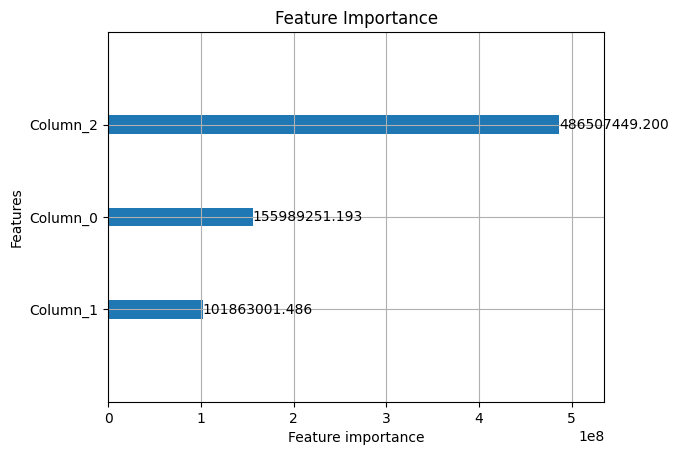

In [242]:
lgb.plot_importance(final_model, max_num_features=30, importance_type='gain')
plt.title("Feature Importance")
plt.show()